# Исследование тарифов сотовой связи.

### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

**Входные данные** —  данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Цель исследования** — проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Гипотезы для проверки:**
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Описание тарифов**
1. Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля, сообщение: 3 рубля, 1 Гб интернет-трафика: 200 рублей

2. Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль, сообщение: 1 рубль, 1 Гб интернет-трафика: 150 рублей

**Примечание:**
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.



**Ход исследования**

Путь к файлам:
- /datasets/calls.csv
- /datasets/internet.csv
- /datasets/messages.csv
- /datasets/tariffs.csv
- /datasets/users.csv

Исследование пройдет в **5 этапов:**
1. Изучение общей информации о данных.
2. Предобработка данных.
3. Анализ данных.
4. Проверка гипотез.
5. Общие выводы. 

### Обзор данных.

In [1]:
#проигнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# импорт библиотек
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats as st

In [3]:
# чтение файлов с данными и их сохранение
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv') 
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
#добавим в каждую таблицу столбец с номером месяца из соответствующей колонки с датой каждой таблицы
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
users['month'] = pd.DatetimeIndex(users['reg_date']).month 
messages['month'] = pd.DatetimeIndex(messages['message_date']).month 

In [10]:
#объединим данные в сводную таблицу по идентификатору пользователя и месяцу

calls = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
messages = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns = {'id': 'messages'}).reset_index()

report = calls.merge(internet, on = ['user_id', 'month'], how = 'outer')\
              .merge(messages, on = ['user_id', 'month'], how = 'outer').fillna(0)
report = report.merge(users, on = 'user_id', how = 'left').merge(tariffs, left_on = 'tariff', 
                                                                 right_on = 'tariff_name', how = 'left')
report.head()

,user_id,month_x,duration,mb_used,messages,age,churn_date,city,first_name,last_name,...,tariff,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,150.06,2253.49,22.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,158.90,23233.77,60.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,318.80,14003.64,75.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,389.87,14055.93,81.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,440.14,14568.91,57.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30720,3000,1950,150,1,1,ultra


In [11]:
# получение общей информации о данных в новой сводной таблице
report.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month_x                3214 non-null   int64  
 2   duration               3214 non-null   float64
 3   mb_used                3214 non-null   float64
 4   messages               3214 non-null   float64
 5   age                    3214 non-null   int64  
 6   churn_date             187 non-null    object 
 7   city                   3214 non-null   object 
 8   first_name             3214 non-null   object 
 9   last_name              3214 non-null   object 
 10  reg_date               3214 non-null   object 
 11  tariff                 3214 non-null   object 
 12  month_y                3214 non-null   int64  
 13  messages_included      3214 non-null   int64  
 14  mb_per_month_included  3214 non-null   int64  
 15  minu

Итак, в таблице 21 столбец. 
Типы данных в столбцах — float, int и object.

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана
- messages - кол-во отправдленных сообщений каждым пользователем помесячно 
- duration — длительность звонков каждого пользователя в минутах помесячно 
- mb_used — объём потраченного интернет-трафика каждого пользователя (в мегабайтах) помесячно 
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [12]:
# подсчёт пропусков 
display(report.isna().sum())

user_id                     0
month_x                     0
duration                    0
mb_used                     0
messages                    0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
month_y                     0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
tariff_name                 0
dtype: int64

Пропуски только в столбце churn_date (дата прекращения пользования тарифом), но их заполнять не надо, так как значит на момент выгрузки тариф еще действовал. 

#### Вывод: На данном этапе мы изучили общую информацию о данных. Объеденили данные в сводную таблицу для удобства работы с данными. 

### Подготовка данных.

In [13]:
#переведем использованные Mb трафика в Gb и округлим в большую сторону 
report['mb_used'] = (report['mb_used'] / 1024)
report['mb_per_month_included'] = (report['mb_per_month_included'] / 1024)

In [14]:
%%time
report['mb_used'] = report['mb_used'].apply(pd.np.ceil) 

CPU times: user 434 µs, sys: 138 µs, total: 572 µs
Wall time: 586 µs


In [15]:
%%time
report['mb_used'] = np.ceil(report['mb_used'])

CPU times: user 381 µs, sys: 121 µs, total: 502 µs
Wall time: 512 µs


In [16]:
#округлим использованные минуты в большую сторону 
report['duration'] = report['duration'].apply(pd.np.ceil)

report.head(10) #проверка результата 

,user_id,month_x,duration,mb_used,messages,age,churn_date,city,first_name,last_name,...,tariff,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,151.0,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
1,1000,6,159.0,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
2,1000,7,319.0,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
3,1000,8,390.0,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
4,1000,9,441.0,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
5,1000,10,329.0,15.0,73.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
6,1000,11,320.0,15.0,58.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
7,1000,12,313.0,10.0,70.0,52,NaN,Краснодар,Рафаил,Верещагин,...,ultra,5,1000,30.0,3000,1950,150,1,1,ultra
8,1001,11,409.0,18.0,0.0,41,NaN,Москва,Иван,Ежов,...,smart,11,50,15.0,500,550,200,3,3,smart
9,1001,12,392.0,14.0,0.0,41,NaN,Москва,Иван,Ежов,...,smart,11,50,15.0,500,550,200,3,3,smart


In [17]:
#напишем функцию для расчета месечной выручки с каждого пользователя и добавим сумму в соответствующий новый столбец
def revenue(row):
    pay_min = 0
    pay_message = 0
    pay_internet = 0
    if (row['duration'] - row['minutes_included']) > 0:
        pay_min = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    if (row['mb_used'] - row['mb_per_month_included']) > 0:
        pay_internet = (row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb']
    if (row['messages'] - row['messages_included']) > 0:
        pay_message = (row['messages'] - row['messages_included']) * row['rub_per_message']
    result = pay_min + pay_message + pay_internet + row['rub_monthly_fee']
    return result

In [18]:
report['revenue_per_month'] = report.apply(revenue, axis=1)

In [19]:
report.head() #проверка результата 

,user_id,month_x,duration,mb_used,messages,age,churn_date,city,first_name,last_name,...,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue_per_month
0,1000,5,151.0,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,...,5,1000,30.0,3000,1950,150,1,1,ultra,1950.0
1,1000,6,159.0,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,...,5,1000,30.0,3000,1950,150,1,1,ultra,1950.0
2,1000,7,319.0,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,...,5,1000,30.0,3000,1950,150,1,1,ultra,1950.0
3,1000,8,390.0,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,...,5,1000,30.0,3000,1950,150,1,1,ultra,1950.0
4,1000,9,441.0,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,...,5,1000,30.0,3000,1950,150,1,1,ultra,1950.0


In [20]:
report.tail() #проверка результата 

,user_id,month_x,duration,mb_used,messages,age,churn_date,city,first_name,last_name,...,month_y,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue_per_month
3209,1489,8,0.0,11.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,...,8,50,15.0,500,550,200,3,3,smart,550.0
3210,1489,9,0.0,17.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,...,8,50,15.0,500,550,200,3,3,smart,950.0
3211,1489,10,0.0,20.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,...,8,50,15.0,500,550,200,3,3,smart,1550.0
3212,1489,11,0.0,18.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,...,8,50,15.0,500,550,200,3,3,smart,1150.0
3213,1489,12,0.0,17.0,35.0,35,NaN,Санкт-Петербург,Павел,Гончаров,...,8,50,15.0,500,550,200,3,3,smart,950.0


#### Вывод: На данном этапе мы подготовили данные для дальнейшего анализа. Добавили необходимый столбец с месячной выручкой, перевели данные о минутах разговоров и использованном трафике в нужные ед. измерения, а также округлили согласно правилам компании «Мегалайн». 

### Анализ данных.

Проанализируем поведение клиентов оператора, исходя из выборки. 
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитаем среднее количество, дисперсию и стандартное отклонение. 
- Построим гистограммы. Опишем распределения.

In [21]:
#сформируем 2 выборки данных по используемому тарифам: Смарт или Ультра
smart = report[report['tariff_name'] == 'smart']
ultra = report[report['tariff_name'] == 'ultra']

In [22]:
#сгруппируем данные по тарифу и для кадого тарифа посчитаем среднее количество, дисперсию и стандартное отклонение для звонков, интернет трафика и сообщений 
report.groupby('tariff')[['duration', 'mb_used', 'messages']].agg({'mean', 'var', 'std'}).style.format('{:.0f}')

In [23]:
report.groupby('tariff')[['duration', 'mb_used',
                          'messages',]].agg({'mean', 'var', 'std'}).style.format('{:.0f}')

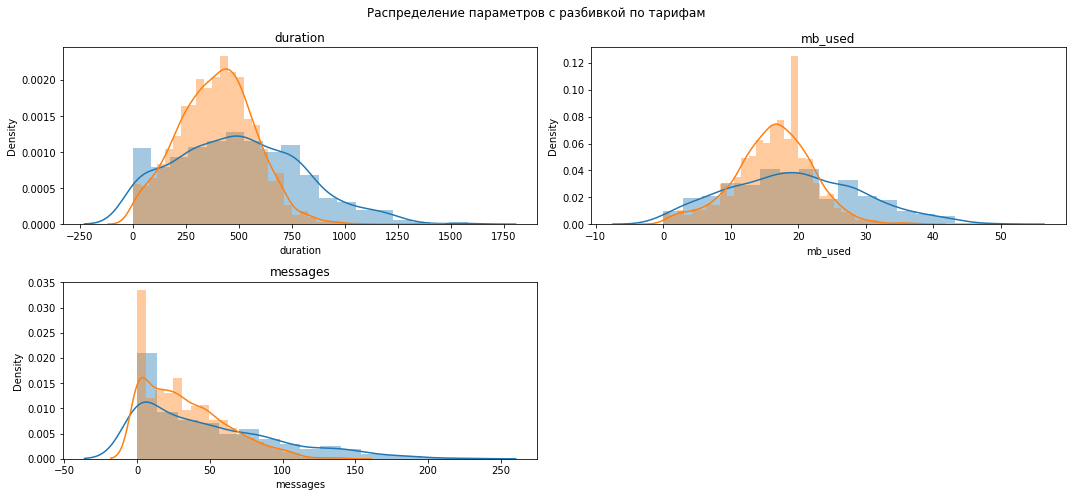

In [24]:
#построим гистограммы
params = ['duration', 'mb_used', 'messages']
col_count, row_count = 2, 2 #число рядов и столбцов в сетке графиктов 

plt.figure(figsize = (15, 7))
for i, param in enumerate(params):
    for tariff in report['tariff'].unique():
        current = report.query('tariff == @tariff')
        sns.distplot(current[param], label = tariff,
                    ax = plt.subplot(row_count, col_count, i + 1)) #задаем положение графика в сетке, i + 1 - порядковый номер графика 
        plt.title(param)

plt.suptitle('Распределение параметров с разбивкой по тарифам')
plt.tight_layout()

#### Вывод: 

1. Пользователям тарифа "Смарт" требуется в среднем в месяц 395 минут, 16 Гб интернет-трафика и 33 сообщения. 
2. Пользователям тарифа "Ультра" требуется в среднем в месяц 498 минут, 19 Гб интернет-трафика и 49 сообщений. 
3. Таким образом, пользователи тарифа "Ультра" тратят на 21% больше минут, на 16% больше трафика и на 33% больше сообщений, чем пользователи тарифа "Смарт". 


In [25]:
xx = report.groupby('tariff').agg({'duration':'mean', 'mb_used':'mean', 'messages':'mean'})
xx

,duration,mb_used,messages
tariff,,,
smart,394.922387,16.328847,33.384029
ultra,497.547208,19.494416,49.363452


In [26]:
(1 - xx.loc['smart']/xx.loc['ultra'])*100

duration    20.626148
mb_used     16.238338
messages    32.370960
dtype: float64

### Проверка гипотез.

- Гипотеза 1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- Гипотеза 2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [27]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

#### Гипотеза 1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Нулевая гипотеза: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

Альтернативная гипотеза: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [28]:
results = st.ttest_ind(
    ultra['revenue_per_month'], 
    smart['revenue_per_month'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.513773301175091e-178
Отвергаем нулевую гипотезу


Вывод: 
Согласно проведенному тесту, мы принимаем за истину альтернативную гипотезу - Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

#### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

Альтернативная гипотеза: Средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

In [29]:
#сформируем 2 выборки: пользователи из Москвы и все остальные пользователи из регионов 
msk = report[report['city'] == 'Москва'] 
region = report[report['city'] != 'Москва'] 

In [30]:
results = st.ttest_ind(
    msk['revenue_per_month'], 
    region['revenue_per_month'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.4836504757759247
Не получилось отвергнуть нулевую гипотезу


Вывод:
Отвергнуть нулевую гипотезу, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других городов не удалось, следовательно, принимаем ее за истину. 

### Общий вывод

Входные данные — данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

Цель исследования — скорректировать рекламный бюджет, выяснить, какой тариф приносит больше денег.

Гипотезы для проверки:

1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Основное исследование прошло в 5 этапов:

##### 1. Изучение общей информации о данных.
На данном этапе мы изучили общую информацию о данных в таблицах и увидели, с чем предстоит иметь дело.
- Мы объеденили данные в сводную таблицу для удобства работы с данными.
- В двух столбцах (days_employed и total_income) были пропущенны значения.
- Пропуски присутствовали только в столбце churn_date (дата прекращения пользования тарифом), но их заполнять не надо, так как значит на момент выгрузки тариф еще действовал.

##### 2.  Предобработка данных.
На втором этапе мы подготовили данные ддля дальнейшего анализа. А именно:
- перевели использованные Mb трафика в Gb и округлили в большую сторону
- округлили использованные минуты в большую сторону 
- посчитали и добавили в новый столбец данные с месячной выручкой по каждому клиенту 

##### 3. Анализ данных 
На третьем этапе мы проанализировали поведение клиентов оператора, исходя из выборки: 
1. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
2. Посчитали среднее количество, дисперсию и стандартное отклонение.
3. Построили гистограммы. 

##### 4. Проверка гипотез.
На четвертом этапе с помощью тестов мы проверили 2 гипотезы и сделали следующие выводы:
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
- Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.


##### 5. Общий вывод
Исходя из проведенного t-теста, можно сделать вывод, что преспективнее тот тариф, у которого средняя выручка выше - то есть тариф "Ультра".
